# 01 Classification with PyTorch 
## Introduction
In this exercise, we consider the task of classifying data comprising two classes using __supervised learning__. In supervised learning a model is trained (that is, fitted) to data consisting of (ideally) unambiguously labeled data. For classification, the label is the class to which a given data vector (also known as a __feature vector__) belongs, while for regression the labels are the values associated with the feature vectors. 
A feature vector could be, for example, the pixel values of a flattened 2D image.

You will build a __binary__ classifier in which one class is labeled with the __target__ $t = 1$ while the other is labeled with the target $t = 0$ and each object to be classified is characterized by data $\mathbf{x}$. That is, the data set is $\{(t_i, \mathbf{x}_i \}$. The fundamental assumption of almost all machine learning models is that the data are presumed to be drawn from a joint probability density function (or, for discrete data, probability mass function), $p(t, \mathbf{x})$.

We shall use the machine learning model 

$$f(\mathbf{x}, \theta) = \mbox{sigmoid}(\,\mathbf{b}_1 + \mathbf{w}_1 \, \mbox{relu}(\mathbf{b}_0 + \mathbf{w}_0 \, \mathbf{x}) \, ),$$

where $\mathbf{b}$ and $\mathbf{w}$ (the biases and weights) are the parameters $\theta$ of the model and $\mbox{relu}(x)$ is a function applied to every element $x_i$ of its tensor argument (i.e., applied element-wise) defined by

\begin{align*}
\mbox{relu}(x) & = \begin{cases}
    x, & \text{if } x \gt 0\\
    0              & \text{otherwise}.
\end{cases}
\end{align*}

The functions sigmoid and relu are implemented in the PyTorch functions
torch.nn.__Sigmoid__() and torch.nn.__ReLU__(), respectively. In this exercise, $\mathbf{b}_1$ is a scalar since we have just one output.


## Recap: Bayes' Theorem

Let

$
\begin{align}
    p(A) & = \textrm{Probability of } A,\\
    p(B) & = \textrm{Probability of } B,\\
    \textrm{and } p(AB) = p(A \cap B ) & = \textrm{Probability of } A \textrm{ and } B,
\end{align}
$

then,

$
\begin{align}
    p(A | B) & = \frac{p(AB)}{p(B)},
\end{align}
$

is called the *conditional probability* of $A$ given $B$. This is answering the question: what is the chance that $A$ is true given that $B$ is true. For example, let $B = \textrm{it is a cat}$ and let $A = \textrm{the fur is white}$, then $p(A | B)$ is the probability that the fur is white given that it is a cat.

From the definition of conditional probability, it follows that
$p(AB) = p(A | B) \, p(B)$. But, by swapping $A$ and $B$ on both sides of that equation, it is also true that $p(BA) = p(B | A) \, p(A)$. But, since $p(AB) = p(BA)$, this leads to 

$
\begin{align}
    p(\color{red}{B} | A ) & = \frac{p(A | \color{red}{B}) \, p(\color{red}{B})}{p(A)},
\end{align}
$

which is __Bayes' Theorem__ (Thomas Bayes, 1763).

Suppose we have multiple $B$s, $B_k$, $k = 1, \cdots$ and the set of $B$s is *exhaustive*, that is, it contains all possible (relevant) $B_k$, then Bayes' theorem becomes

$
\begin{align}
    p(B_k | A ) & = \frac{p(A | B_k) \, p(B_k)}{p(A)}.
\end{align}
$

Because the set of $B_k$ is *exhaustive*, it follows that 

$
\begin{align}
    \sum_k p(B_k | A ) & = 1.
\end{align}
$

Consequently, $p(A)$ must satisfy the sum rule

$
\begin{align}
        p(A) & = \sum_k p(A | B_k) \, p(B_k), \\
            & = \sum_k p(A B_k) .
\end{align}
$


## Loss function
Typically, a machine learning model is fitted to the training data by minimizing a suitably defined function, which in the statistics literature is often referred to as the __empirical risk__. (Fitting models to data is called learning by machine learning enthusiasts.) The empirical risk is a Monte Carlo approximation of the __risk functional__, defined by 

\begin{align*}
    R[f] &= \int \cdots \int L(t, \, f(\mathbf{x}, \theta)) \, 
    p(t, \, \mathbf{x}) \, dt \, d\mathbf{x},
\end{align*}

where $L(t, \, f)$ is called the __loss function__ and measures how much one loses if the output of the parameterized function $f(x, \theta)$ differs from the __target__ $t$. $\color{blue}{\rm Warning}$: In the machine learning world, the empirical risk is typicaly referred to as the loss function, when what is really meant is the average loss function. 

__Important Note__: In order for the risk functional $R[f]$ to reach its minimum, defined by variations of $f$ that yield the condition $\delta R = 0$ $\forall \, x$, the function $f$ must be sufficiently flexible. If the latter condition is satisfied, then the mathematical quantity approximated by $f$ depends solely on the form of the loss function $L(t, \, f)$ and the probability distribution $p(t, \, x)$ of the training data. In particular, it does not depend on
    the details of the functon $f$ apart from its presumed flexibility. Of course, in practice, we do not minimize $R[f]$, but rather the empirical risk, which approximates it. Nevertheless, to the degree that a very large data set approximates an infinite one and to the degree that our minimizer is able to find a good approximation to the minimum, this bit of reasoning suggests that it is as least as important to think about the form of the loss function $L(t, \, f)$ as it is to think about the form of the model. If we have two models of equal functional flexibility then, *a priori*, for the same loss function the models will approximate the same quantity. 

In [1]:
import os, sys

# the standard module for tabular data
import pandas as pd

# the standard module for array manipulation
import numpy as np

# the standard modules for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt

#  a function to save results
import joblib as jb

# pytorch
import torch

#  split data into a training set and a test set
from sklearn.model_selection import train_test_split

# to reload modules
import importlib

%matplotlib inline

In [2]:
# update fonts
FONTSIZE = 14
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

### Load data

In [3]:
data = jb.load('data.db')
data[:10]

,target,x,y
0,0.0,-1.528435,2.482336
1,1.0,-0.298034,0.350602
2,1.0,0.844025,0.138175
3,0.0,-1.280748,1.273752
4,0.0,0.519784,-1.486675
5,1.0,0.553385,1.235875
6,0.0,-0.015297,-1.244069
7,1.0,0.933215,0.806885
8,1.0,1.748572,0.978152
9,0.0,1.062602,-1.167001


### Train, validation, and test sets
There is some confusion in terminology regarding validation and test samples (or sets). We shall adhere to the defintions given here https://machinelearningmastery.com/difference-test-validation-datasets/):
   
  * __Training Dataset__: The sample of data used to fit the model.
  * __Validation Dataset__: The sample of data used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters. The evaluation becomes more biased as skill on the validation dataset is incorporated into the model configuration.
  * __Test Dataset__: The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.

The validation set will be some small fraction of the training set and will be used to decide when to stop the training.

In [4]:
fraction = 0.20
train_data, test_data = train_test_split(data, test_size=fraction)

fraction = 0.125
train_data, valid_data = train_test_split(train_data, test_size=fraction)

print('train set size:        %6d' % train_data.shape[0])
print('validation set size:   %6d' % valid_data.shape[0])
print('test set size:         %6d' % test_data.shape[0])

train set size:         35000
validation set size:     5000
test set size:          10000


Split data into targets $t$ and inputs $\mathbf{x}$

In [5]:
def split_t_x(df, inputs=['x', 'y']):
    # change from pandas dataframe format to a numpy 
    # array of the specified types
    t = df['target'].to_numpy().astype(np.long)
    x = df[inputs].to_numpy().astype(np.float32)
    return (t, x)

train_t, train_x = split_t_x(train_data)
valid_t, valid_x = split_t_x(valid_data)
test_t,  test_x  = split_t_x(test_data)

print(train_x[:3], end='\n\n') 
print(valid_x[:3], end='\n\n')
print(test_x[:3],  end='\n\n')

[[ 1.8759602   1.6548501 ]
 [-0.5391906  -0.89200723]
 [ 0.43230608 -1.3800026 ]]

[[ 0.7940733   1.4197329 ]
 [ 0.26457557 -1.9704969 ]
 [-0.20728141 -1.3524994 ]]

[[-0.46819124 -1.0124339 ]
 [ 0.17062046  1.2169482 ]
 [ 2.65047    -1.8208842 ]]



### Some useful tensor operations

In [6]:
# create a float tensor
a = torch.Tensor([[1,2], [3,4]])
print(a)

# create an integer tensor, which we'll use for gathering  
# elements of the [2,2] tensor 'a' along its dim=1 
# (that is, horizontal) dimension.
i = torch.tensor([1,0])
print(i)

# note that since we're gathering along the dim=1 dimension
# of 'a' the tensor 'i' must be of the same shape as 'a'
# along other dimensions besides dim=1, that is, along dim=0.
# by using view(-1,...) we make the dim=0 (vertical)
# dimension of i be of the same length as the dim=0 
# dimension of 'a'.
b  = a.gather(dim=1, index=i.view(-1, 1))
print(b)

# now we get rid of extraneous dimensions.
# compare tensors 'b' and 'c'. in 'b' there is only one 
# element per row along dim=1, so its shape is [2, 1]. 
# We are, therefore, free to squeeze away the dim=1 to
# arrive at a new tensor 'c' with shape [2,]
c = b.squeeze()
print(c)

tensor([[1., 2.],
        [3., 4.]])
tensor([1, 0])
tensor([[2.],
        [3.]])
tensor([2., 3.])


### Return a (random) batch of data from the training set

In [7]:
def get_batch(x, t, batch_size):
    # the numpy function choice(length, number)
    # selects at random "number" integers from the range [0, length-1]
    rows    = rnd.choice(len(x), batch_size)
    batch_x = x[rows]
    batch_t = t[rows]
    return (batch_x, batch_t)

### Empirical risk (that is, average loss)

The empirical risk, which is the __objective function__ we shall minimize, is defined as

\begin{align}
R_M(\theta) & = \frac{1}{M}\sum_{m=1}^M L(t_m, f_m),
\end{align}

where 

\begin{align}
    f_m & \equiv f(\mathbf{x}_m, \theta),\\ \\ \textrm{and} \\
    L(t, f) &= -\ln[f^t \, (1 - f)^{1 - t}], \\
            &= 
\begin{cases}
    -\ln f, & \text{if } t == 1\\
    -\ln (1-f)             & \text{otherwise}.
\end{cases}
\end{align}

The empirical risk $R_M$ approximates the __risk__

\begin{align}
R[f] & = \int \cdots \int \, p(t, \mathbf{x}) \, L(t, f(\mathbf{x}, \theta)) \, dt \, d\mathbf{x},
\end{align}

which is a __functional__ of the model $f$. The quantity $p(t, \mathbf{x}) \, dt\, d\mathbf{x}$ is the probability distribution from which the sample $\{ (t_m, \mathbf{x}_m), m = 1,\cdots, M \}$ is presumed to have been drawn. 

In [8]:
def average_loss(f, t):
    losses =-torch.where(t > 0.5, torch.log(f), torch.log(1-f))   
    return torch.mean(losses) 

### Define accuracy of model

Let's define accuracy as the fraction of the sample that is correctly classified. Recall, that if we use either the __quadratic loss__ 

$$L(t, f) = (t - f)^2$$

or the __cross entropy loss__

$$L(t, f) =- [t \, \ln(f) + (1 - t) \ln(1-f)],$$

the model $f(\mathbf{x}, \theta)$ will approximate the mean of $p(t | \mathbf{x})$, that is,

$$f(\mathbf{x}, \theta^*) \approx p(1 | \mathbf{x}) 
= \frac{p(\mathbf{x} | 1) \, p(1)}{p(\mathbf{x} | 1) \, p(1) + p(\mathbf{x} | 0) \, p(0)},$$

provided that
   1. We have a lot of training data (strictly, an infinite amount).
   2. We have a sufficienty flexible model $\forall \, \mathbf{x}$.
   3. We have an effective optimizer so that we can find the best fit parameter point $\theta^*$.
   
  
If an object, characterized by $\mathbf{x}$, yields $f(\mathbf{x}, \theta^*) \approx p(1 | \mathbf{x}) > 0.5$ we'll assign it to the class with $t = 1$, otherwise it is assigned to the class with $t = 0$.

In [9]:
def accuracy(f, t):
    # Count how many times the predicted target matches 
    # the true target and convert to a fraction.
    s = (f > 0.5).long()   # convert to long ints
    a = (s == t).float()   # convert to floats
    return float(torch.mean(a))

### Function to execute training loop

Note, here we use $t$ and $y$ interchangeably to denote the targets

In [10]:
def train(model, optimizer, avloss, getbatch,
          train_x, train_y, 
          valid_x, valid_y,
          batch_size, 
          n_iterations, step=10):
    
    xx   = []
    yy_t = []
    yy_v = []
    n    = 5000
    
    # set mode to training so that training specific operations such 
    # as dropout are enabled.
    model.train()
    
    for ii in range(n_iterations):

        # Get a random sample (a batch) of images (as numpy arrays)
        batch_x, batch_y = getbatch(train_x, train_y, batch_size)
        
        # Convert the numpy arrays batch_x and batch_y, to tensor 
        # types. The PyTorch tensor type is the magic that permits 
        # automatic differentiation with respect to parameters. 
        # However, since we do not need to take the derivatives
        # with respect to x and y, we disable this feature
        with torch.no_grad(): # no need to compute gradients wrt. x and y
            x = torch.from_numpy(batch_x)
            y = torch.from_numpy(batch_y)      

        # compute the output of the model for the batch of data x
        outputs = model(x)
        
        # compute a noisy approximation to the average loss
        empirical_risk = avloss(outputs, y)
        
        # use automatic differentiation to compute a 
        # noisy approximation of the local gradient
        optimizer.zero_grad()       # clear previous gradients
        empirical_risk.backward()   # compute gradients
        
        # Finally, advance one step in the direction of steepest 
        # descent, using the noisy local gradient. 
        optimizer.step()            # move one step
        
        if ii % step == 0:
            acc_t = validate(model, train_x[:n], train_y[:n]) 
            acc_v = validate(model, valid_x[:n], valid_y[:n])
            
            print("\r%10d\t%10.4f\t%10.4f" % (ii, acc_t, acc_v), end='')
        
            xx.append(ii)
            yy_t.append(acc_t)
            yy_v.append(acc_v)
            
    return (xx, yy_t, yy_v)

In [11]:
def validate(model, xx, yy):
    # make sure we set evaluation mode so that training specific
    # operations such as dropout are disabled.
    model.eval() # evaluation mode
    
    with torch.no_grad(): # no need to compute gradients wrt. x and y
        # compute accuracy using training sample
        x = torch.from_numpy(xx)
        y = torch.from_numpy(yy)
        o = model(x)
        acc = accuracy(o, y)
    return acc

In [12]:
def plot_accuracy(traces):
    
    xx, yy_t, yy_v = traces
    
    # create an empty figure
    fig = plt.figure(figsize=(5, 5))
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)
    # adjust y limits
    axes = ax.axes
    axes.set_ylim((0, 1))
    axes.set_xlim((0, xx[-1]))
    
    plt.plot(xx, yy_t, 'b', label='Training')
    plt.plot(xx, yy_v, 'r', label='Validation')
    plt.title('Training and Validation Errors')
    plt.xlabel('Iterations', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.grid(True, which="both", linestyle='-')
    plt.legend(loc='lower right')
    plt.show()

### Define model $f(\mathbf{x}, \theta)$

The output non-linearity is chosen to be a __sigmoid__ function:

$$g(z) = \frac{1}{1 + \exp(-z)}.$$

In [19]:
N_INPUTS  = 2       # number of inputs (x1, x2)
N_NODES_0 = 2       # number of nodes in layer 0
N_NODES_1 = 1       # number of nodes in layer 1 (output layer)     

# Instead of create our own class, let's just use the Sequential class.
# Try to guess what's going on here.
model = torch.nn.Sequential(
             torch.nn.Linear(N_INPUTS,  N_NODES_0),
             torch.nn.ReLU(),
             torch.nn.Linear(N_NODES_0, N_NODES_1),
             torch.nn.Sigmoid()
     )

print (model)

Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): ReLU()
  (2): Linear(in_features=2, out_features=1, bias=True)
  (3): Sigmoid()
)


### Train!

Instantiate an optimizer, then train

In [20]:
n_batch = 10
n_iterations = 200
learning_rate = 0.003

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

traces = train(model, optimizer, 
               average_loss,
               get_batch,
               train_x, train_t, 
               valid_x, valid_t,
               n_batch, 
               n_iterations,
               step=1)

       199	    0.5389	    0.5383

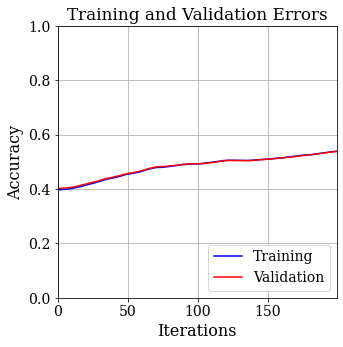

In [21]:
plot_accuracy(traces)